# Bank Marketing

The data is related with direct marketing campaigns of a Portuguese banking institution.The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required,in order to access if the product (bank term deposit) would be (or not) subscribed.

The classification goal is to predict if the client will subscribe a term deposit (variable y).


## Attribute Information:

### Dank client data:
- age (numeric)
- job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
- marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
- education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
- default: has credit in default? (categorical: 'no','yes','unknown')
- balance: average yearly balance, in euros (numeric)
- housing: has housing loan? (categorical: 'no','yes','unknown')
- loan: has personal loan? (categorical: 'no','yes','unknown')

### Related with the last contact of the current campaign:
- contact: contact communication type (categorical: 'cellular','telephone') 
- month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
- day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
- duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

### Other attributes:
- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
- pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
- previous: number of contacts performed before this campaign and for this client (numeric)
- poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

### Output variable (target):
- y - has the client subscribed a term deposit? (binary: 'yes','no')

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import (cohen_kappa_score,make_scorer,f1_score,precision_score,recall_score,accuracy_score)
from sklearn.metrics import confusion_matrix

C:\Users\RAA090\AppData\Local\conda\conda\envs\smarter_reefer\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Loading data
bank_data = pd.read_csv('C:/Users/RAA090/Documents/Personal/data_sets/Bank Marketing Data Set/bank/bank-full.csv')


In [3]:
# Dimensions of data
print(bank_data.shape)

(45211, 17)


In [4]:
# Seeing top 5 records of data
bank_data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [5]:
bank_data.drop(["duration"],axis=1,inplace=True)

In [6]:
bank_data.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

In [7]:
categorical_vars = ["marital","job","contact","education","month","poutcome","housing","loan","default"]

In [8]:
numeric_vars = ["age","balance","day","campaign","pdays","previous"]

In [9]:
bank_data[numeric_vars] = bank_data[numeric_vars].astype('int')

## Missing value

In [10]:
bank_data.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [11]:
np.isnan(bank_data[numeric_vars]).sum()

age         0
balance     0
day         0
campaign    0
pdays       0
previous    0
dtype: int64

# Exploratory analysis

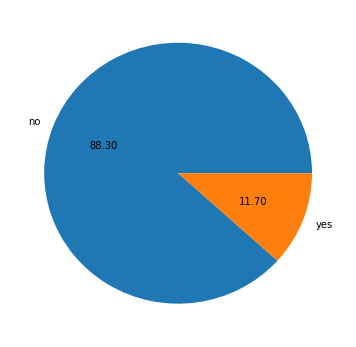

In [12]:
fig1,ax1 = plt.subplots(figsize=(6, 6))
ax1.pie(x=bank_data.y.value_counts().values ,labels= bank_data.y.value_counts().index, autopct='%.2f' )
plt.show()

In [13]:
numeric_vars + ['y']

['age', 'balance', 'day', 'campaign', 'pdays', 'previous', 'y']

Text(0.5,0.98,'Age')

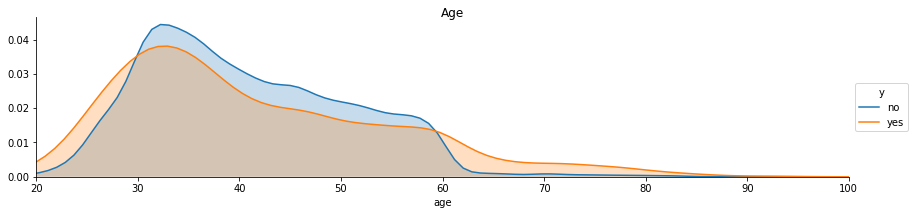

In [14]:
fig = sns.FacetGrid(bank_data[numeric_vars + ['y']], hue='y', aspect=4) 
fig.map(sns.kdeplot,'age',shade=True)
# max_x = df.station_avg_temp_c.max()
fig.set(xlim=(20,100))
fig.add_legend()
fig.fig.suptitle("Age")

Text(0.5,0.98,'Age')

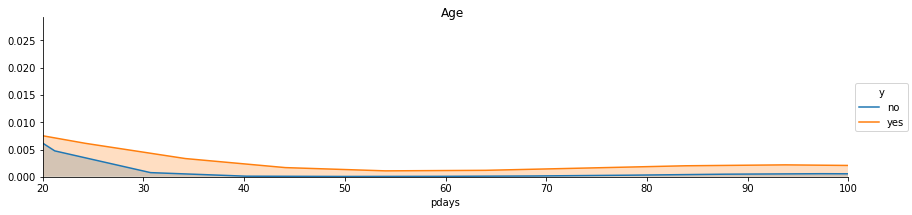

In [15]:
fig = sns.FacetGrid(bank_data[numeric_vars + ['y']], hue='y', aspect=4) 
fig.map(sns.kdeplot,'pdays',shade=True)
# max_x = df.station_avg_temp_c.max()
fig.set(xlim=(20,100))
fig.add_legend()
fig.fig.suptitle("Age")

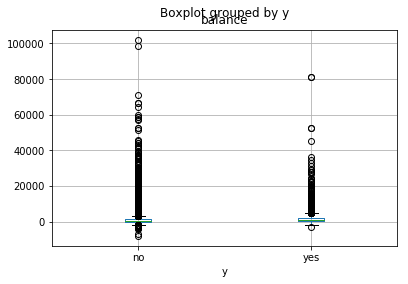

In [16]:
bank_data.boxplot(column=['balance'],by='y')

# Feature engineering

# Model building validation and performance

In [17]:
X_dummies = pd.get_dummies(bank_data[categorical_vars])

In [18]:
bank_data_with_dummies = pd.concat([bank_data[numeric_vars],X_dummies,bank_data[['y']]],axis=1)

In [19]:
selected_faettures = [col for col in bank_data_with_dummies.columns if col != 'y' ]

In [20]:
X = bank_data_with_dummies[selected_faettures]

In [21]:
y = bank_data_with_dummies['y'].map({'yes':1, 'no': 0})

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.33, random_state=42)

## Downsampling

In [23]:
X_train_down_sampled, y_train_down_sampled = RandomUnderSampler(random_state = 12).fit_sample(X_train, y_train)

## Over sampling

In [24]:
X_train_over_sampled, y_train_over_sampled = SMOTE(random_state = 12,ratio={0:26747, 1:11463}).fit_sample(X_train, y_train)

In [29]:
logit = LogisticRegression()
rf = RandomForestClassifier()
gbm = GradientBoostingClassifier()

In [37]:
def modelfit(algo, train_x,train_y,test_x,test_y, num_fold,model_name):
    
    model = algo.fit(train_x,train_y)
    ## probability prediction
    predicted_proba  = model.predict_proba(test_x)
    predicted_proba = pd.DataFrame(predicted_proba.tolist()).iloc[:,1]
    
    ## cross validation scorer with stratified folds
    strat_k_fold = strat_k_fold = StratifiedKFold(n_splits=3,random_state= 10).get_n_splits(X=train_x,y=y_train)
    ## cv score
    cv_scores_kappa = cross_val_score(model,train_x,train_y,cv=strat_k_fold,scoring=make_scorer(cohen_kappa_score))
    cv_scores_accuracy = cross_val_score(model,train_x,train_y,cv=strat_k_fold,scoring=make_scorer(accuracy_score))
    cv_scores_f1 = cross_val_score(model,train_x,train_y,cv=strat_k_fold,scoring=make_scorer(f1_score))
    
    ## feature importances
    if(model_name == "logistic"):
        importances = model.coef_
        importances = importances[0]
    else:
        importances = model.feature_importances_

    
    
    ## Recursive feature selection with cross validation
    rfecv = RFECV(estimator=model, step=2, cv=StratifiedKFold(n_splits=num_fold).split(train_x, train_y),
              scoring= make_scorer(cohen_kappa_score) )
    rfecv.fit(train_x, train_y)
    rfecv_num_features = rfecv.n_features_
    rfecv_ranking = rfecv.ranking_ 
    rfecv_support = rfecv.support_
    rfecv_grid_scores = rfecv.grid_scores_
    ## rfecv plot
    rfecv_fig, rfecv_ax = plt.subplots()
    rfecv_ax.set_title(model_name +'_' +str(rfecv.n_features_))
    rfecv_ax.set_xlabel("Number of features selected")
    rfecv_ax.set_ylabel("Cross validation score (nb of correct classifications)")
    rfecv_ax.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    
    
    feature_imp_temp = pd.DataFrame({model_name:importances})
    cv_scores_temp = pd.DataFrame({'cv_scores_accuracy':cv_scores_accuracy,'cv_scores_kappa':cv_scores_kappa,'model_name':model_name})
    rfecv_temp = pd.DataFrame({ model_name + "_support":rfecv_support,model_name + "_ranking":rfecv_ranking})
    rfecv_grid_scores_temp = pd.DataFrame({model_name:rfecv_grid_scores})
    predicted_proba_temp = pd.DataFrame({model_name: predicted_proba})
    
    metrics_df = pd.DataFrame()
    for threshold in np.arange(0,1.1,.1):
        p_label = [1 if  x > threshold else 0 for x in predicted_proba]
        kappa = cohen_kappa_score(test_y,p_label)
        f1 = f1_score(y_pred=p_label,y_true=test_y)
        precision = precision_score(y_pred=p_label,y_true=test_y)
        recall = recall_score(y_pred=p_label,y_true=test_y)

        ## confusion matrix
        confusion_matrix1 = pd.DataFrame(confusion_matrix(y_true=test_y,y_pred=p_label))
        _0_0 = confusion_matrix1.iloc[0,0]
        _0_1 = confusion_matrix1.iloc[0,1]
        _1_0 = confusion_matrix1.iloc[1,0]
        _1_1 = confusion_matrix1.iloc[1,1]
    
        temp = pd.DataFrame({'threshold': threshold,'kappa':kappa,'f1': f1,'precision':precision,'recall':recall,'_0_0':_0_0,
                                '_0_1':_0_1,'_1_0':_1_0,'_1_1':_1_1},index= [model_name])
        metrics_df = metrics_df.append(temp)
        return {'metrics':metrics_df,'feature':feature_imp_temp}

{'feature':     random_forest
 0        0.133118
 1        0.144221
 2        0.112868
 3        0.062835
 4        0.031631
 5        0.021526
 6        0.010358
 7        0.017748
 8        0.015378
 9        0.013422
 10       0.012632
 11       0.006520
 12       0.003840
 13       0.015090
 14       0.006451
 15       0.007256
 16       0.011654
 17       0.003663
 18       0.014006
 19       0.006233
 20       0.001510
 21       0.015732
 22       0.005448
 23       0.032484
 24       0.011264
 25       0.014176
 26       0.015414
 27       0.006156
 28       0.012097
 29       0.011357
 30       0.002441
 31       0.008209
 32       0.007240
 33       0.012348
 34       0.009978
 35       0.008192
 36       0.014645
 37       0.012256
 38       0.010444
 39       0.004980
 40       0.009037
 41       0.005135
 42       0.033392
 43       0.016185
 44       0.015818
 45       0.027826
 46       0.008786
 47       0.012825
 48       0.001863
 49       0.002311,
 'metrics':        

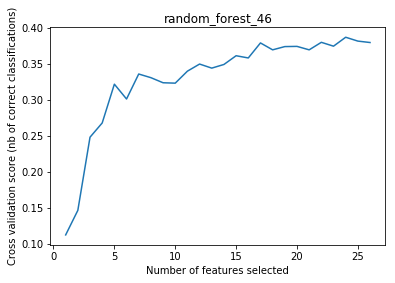

In [38]:
modelfit(algo=rf,model_name="random_forest",num_fold=3,test_x=X_test,test_y=y_test,train_x=X_train_down_sampled,train_y=y_train_down_sampled)

In [ ]:
#     feature_imp_df = pd.concat([feature_imp_temp,feature_imp_df],axis=1)
#     cv_scores_df = cv_scores_df.append(cv_scores_temp,)
#     rfecv_df = pd.concat([rfecv_temp,rfecv_df],axis=1)
#     rfecv_grid_scores_df = pd.concat([rfecv_grid_scores_temp,rfecv_grid_scores_df],axis=1)
#     predicted_proba_df = pd.concat([predicted_proba_temp,predicted_proba_df],axis=1)

In [249]:
# logit = LogisticRegression()
# rf = RandomForestClassifier()
# gbm = GradientBoostingClassifier()

# train_x = X_train
# train_y = y_train
# test_x = X_test
# test_y = y_test

# model_name = 'logistic'

# model = logit.fit(train_x,train_y)
# ## probability prediction

# predicted_proba  = model.predict_proba(test_x)
# predicted_proba = pd.DataFrame(predicted_proba.tolist()).iloc[:,1]

# ## cross validation scorer with stratified folds
# strat_k_fold = strat_k_fold = StratifiedKFold(n_splits=3,random_state= 10).get_n_splits(X=train_x,y=y_train)

# ## cv score
# cv_scores_kappa = cross_val_score(model,train_x, train_y, cv=strat_k_fold, scoring=make_scorer(cohen_kappa_score))

# cv_scores_accuracy = cross_val_score(model,train_x,train_y,cv=strat_k_fold,scoring=make_scorer(accuracy_score))

# cv_scores_f1 = cross_val_score(model, train_x, train_y, cv=strat_k_fold, scoring= make_scorer(f1_score) )



# ## feature importances
# if(model_name == "logistic"):
#     importances = model.coef_
#     importances = importances[0]
# else:
#     importances = model.feature_importances_

# ## Recursive feature selection with cross validation
# rfecv = RFECV(estimator=model, step=2, cv=StratifiedKFold(n_splits=4).split(train_x, train_y),
#           scoring= make_scorer(cohen_kappa_score) )
# rfecv.fit(train_x, train_y)
# rfecv_num_features = rfecv.n_features_
# rfecv_ranking = rfecv.ranking_ 
# rfecv_support = rfecv.support_
# rfecv_grid_scores = rfecv.grid_scores_
# ## rfecv plot
# rfecv_fig, rfecv_ax = plt.subplots()
# rfecv_ax.set_title(model_name +':Number of features ' +str(rfecv.n_features_))
# rfecv_ax.set_xlabel("Number of features selected")
# rfecv_ax.set_ylabel("Cross validation score (nb of correct classifications)")
# rfecv_ax.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)

# feature_imp_temp = pd.DataFrame({model_name:importances})
# cv_scores_temp = pd.DataFrame({'cv_scores_accuracy':cv_scores_accuracy,'cv_scores_kappa':cv_scores_kappa,'model_name':model_name})
# rfecv_temp = pd.DataFrame({ model_name + "_support":rfecv_support,model_name + "_ranking":rfecv_ranking})
# rfecv_grid_scores_temp = pd.DataFrame({model_name:rfecv_grid_scores})
# predicted_proba_temp = pd.DataFrame({model_name: predicted_proba})

# metrics_df = pd.DataFrame()
# for threshold in np.arange(0,1.1,.1):
#     p_label = [1 if  x > threshold else 0 for x in predicted_proba]
#     kappa = cohen_kappa_score(test_y,p_label)
#     f1 = f1_score(y_pred=p_label,y_true= test_y)
#     precision = precision_score(y_pred=p_label,y_true= test_y)
#     recall = recall_score(y_pred=p_label,y_true=test_y)

#     ## confusion matrix
#     confusion_matrix1 = pd.DataFrame(confusion_matrix(y_true=test_y,y_pred=p_label))        
#     temp = pd.DataFrame({'threshold': threshold,'kappa':kappa,'f1': f1,'precision':precision,'recall':recall,'_0_0':_0_0,
#                             '_0_1':_0_1,'_1_0':_1_0,'_1_1':_1_1},index= [col])
#     metrics_df = metrics_df.append(temp)

In [300]:
# for threshold in np.arange(0,1.1,.1):
#     p_label = [1 if  x > threshold else 0 for x in predicted_proba]
#     kappa = cohen_kappa_score(test_y,p_label)
#     f1 = f1_score(y_pred=p_label,y_true=test_y)
#     precision = precision_score(y_pred=p_label,y_true=test_y)
#     recall = recall_score(y_pred=p_label,y_true=test_y)

#     ## confusion matrix
#     confusion_matrix1 = pd.DataFrame(confusion_matrix(y_true=test_y,y_pred=p_label))
#     _0_0 = confusion_matrix1.iloc[0,0]
#     _0_1 = confusion_matrix1.iloc[0,1]
#     _1_0 = confusion_matrix1.iloc[1,0]
#     _1_1 = confusion_matrix1.iloc[1,1]
    
    
#     temp = pd.DataFrame({'threshold': threshold,'kappa':kappa,'f1': f1,'precision':precision,'recall':recall,'_0_0':_0_0,
#                             '_0_1':_0_1,'_1_0':_1_0,'_1_1':_1_1},index= [model_name])
#     metrics_df = metrics_df.append(temp)

C:\Users\RAA090\AppData\Local\conda\conda\envs\smarter_reefer\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\RAA090\AppData\Local\conda\conda\envs\smarter_reefer\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
